# Walkthrough - RBIG

In [314]:
import sys
sys.path.append("../")

# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x64", True)

import numpy as onp
from functools import partial

# library parameters
from rbig_jax.data import get_classic
from rbig_jax.information.reduction import information_reduction
from rbig_jax.plots import plot_info_loss, plot_joint, plot_joint_prob
from rbig_jax.models.rbig import RBIGFlow, RBIGFlowJit
from rbig_jax.transforms.block import (
    init_gauss_hist_block, init_gauss_hist_block_params,
    init_gauss_kde_block, init_gauss_kde_block_params
)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


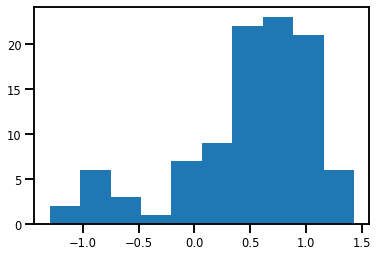

In [3]:
# get data
data = get_classic(100)

# plot data
plt.hist(data[:, 1], 10);

## Logging

In [4]:
wandb.init(project="rbigjax-demo-2d", entity="emanjohnson91")


W&B Run: https://app.wandb.ai/emanjohnson91/rbigjax-demo-2d/runs/v8mzo89a

In [5]:

# config parameters
wandb.config.n_samples = 10_000
wandb.config.dataset = "classic"
wandb.config.method = "histogram"
wandb.config.support_extension = 10
wandb.config.precision = 50
wandb.config.alpha = 0.0
wandb.config.n_layers = 20

wandb: Wandb version 0.10.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## Data

In [6]:
def plot_joint(data, color: str = "red", title: str = "", kind="kde", logger=None):

    plt.figure()
    sns.jointplot(x=data[:, 0], y=data[:, 1], kind=kind, color=color)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    

def plot_joint_prob(data, probs, cmap="Reds", title="", logger=None):

    fig, ax = plt.subplots()
    h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs, cmap=cmap)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.colorbar(h,)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

<Figure size 432x288 with 0 Axes>

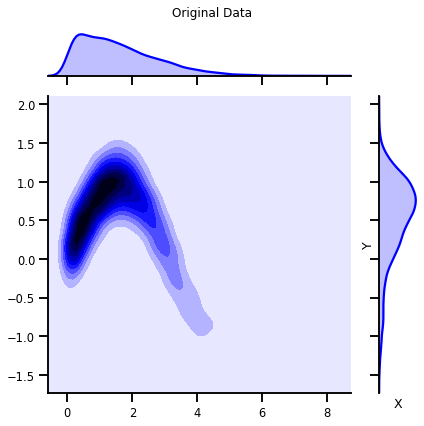

In [7]:
# %%wandb
# get data
data = get_classic(10_000)

# plot data
plot_joint(data, "blue", "Original Data", logger=False)

## Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

## RBIG Block

In [182]:
from rbig_jax.transforms.block import (
    init_gauss_hist_block, 
    init_gauss_hist_block_params,
    forward_gauss_block_transform,
    inverse_gauss_block_transform)

In [183]:
# initialize transformation
init_rbig_transform = init_gauss_hist_block_params()

# forward transformation
X_g, params = init_rbig_transform(np.array(data))

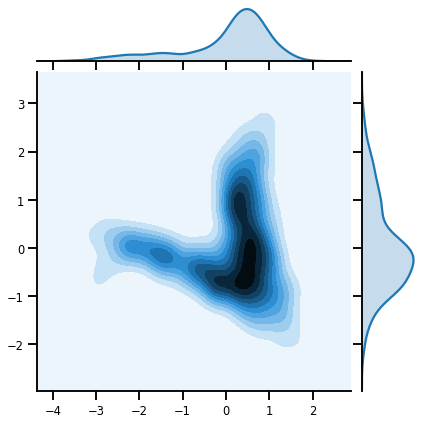

In [184]:
# plot
sns.jointplot(X_g[:1_000, 0], X_g[:1_000, 1], kind='kde')

### Forward Transformation

In [185]:
X_g_f = forward_gauss_block_transform(np.array(data), params)

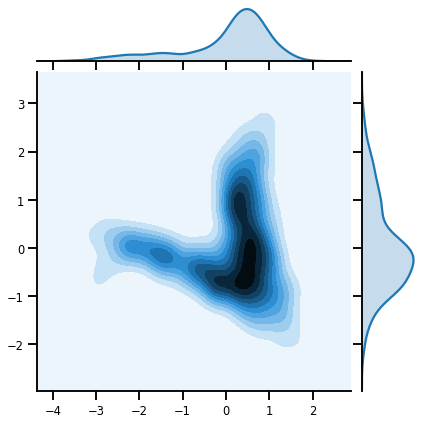

In [186]:
sns.jointplot(X_g_f[:1_000, 0], X_g_f[:1_000, 1], kind='kde')

### Inverse Transform

In [60]:
X_approx = inverse_gauss_block_transform(X_g_f, params)

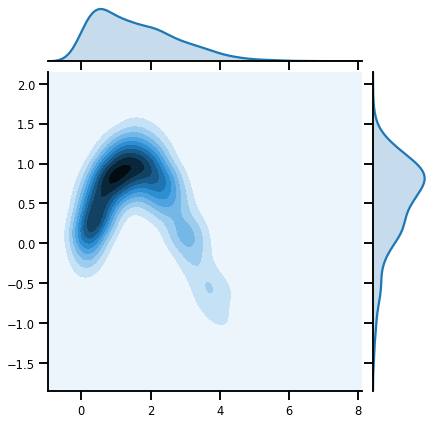

In [61]:
sns.jointplot(X_approx[:1_000, 0], X_approx[:1_000, 1], kind='kde')

#### Speed

In [63]:
%%time

# initialize transformation
init_rbig_transform = init_gauss_hist_block_params()

# forward transformation
X_g, params = init_rbig_transform(np.array(data))

CPU times: user 270 ms, sys: 38.9 ms, total: 309 ms
Wall time: 237 ms


In [64]:
%timeit init_rbig_transform(np.array(data).block_until_ready())

300 ms ± 6.71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [66]:
%%time


# initialize transformation
init_rbig_transform_jitted = jax.jit(init_gauss_hist_block_params())

# forward transformation
X_g, params = init_rbig_transform_jitted(np.array(data))

CPU times: user 6 s, sys: 37.8 ms, total: 6.04 s
Wall time: 6.02 s


In [67]:
%timeit init_rbig_transform_jitted(np.array(data).block_until_ready())

10.3 ms ± 447 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Gaussianization

In [325]:
%%time

# rbig_block = init_gauss_hist_block_params()
rbig_block = init_gauss_kde_block_params()

rbig_flow = RBIGFlow(rbig_block, tol_layers=20, max_layers=1_000)

X_trans = rbig_flow.fit_transform(np.array(data))


CPU times: user 4min 17s, sys: 32.9 s, total: 4min 50s
Wall time: 25.1 s


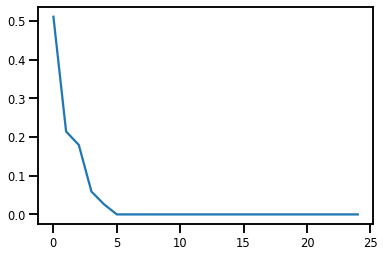

In [326]:
plt.plot(rbig_flow.losses)

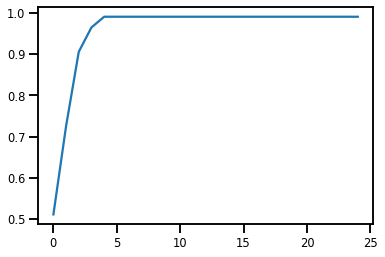

In [327]:
plt.plot(np.cumsum(rbig_flow.losses))

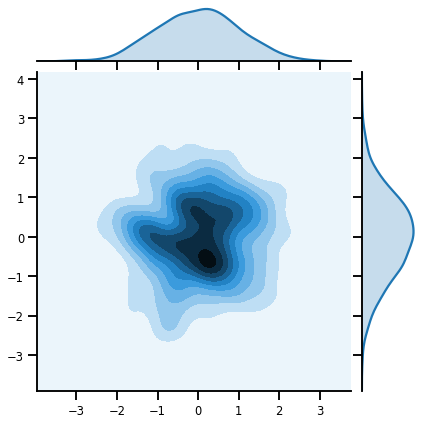

In [328]:
sns.jointplot(X_trans[:1_000, 0], X_trans[:1_000, 1], kind='kde')

In [329]:
X_trans = rbig_flow.transform(np.array(data))

100%|██████████| 25/25 [00:03<00:00,  7.49it/s]


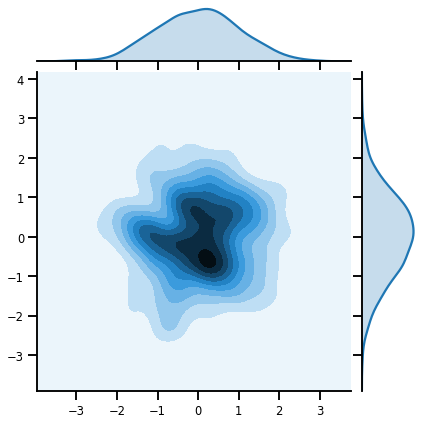

In [330]:
sns.jointplot(X_trans[:1_000, 0], X_trans[:1_000, 1], kind='kde')

In [331]:
X_approx = rbig_flow.inverse_transform(X_trans)

100%|██████████| 25/25 [00:01<00:00, 20.89it/s]


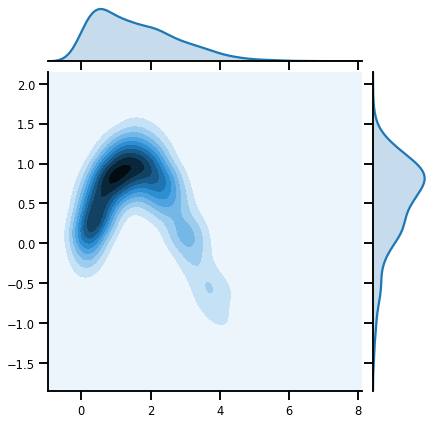

In [332]:
sns.jointplot(X_approx[:1_000, 0], X_approx[:1_000, 1], kind='kde')

100%|██████████| 25/25 [00:01<00:00, 17.79it/s]


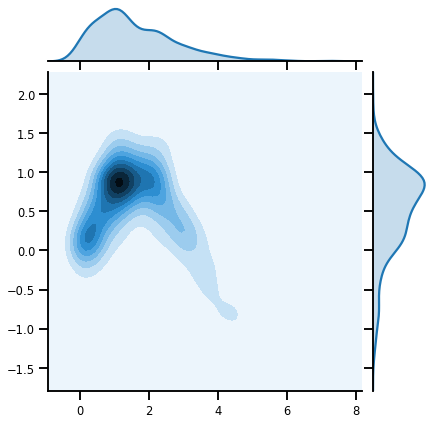

In [333]:
X_samples = rbig_flow.sample(10_000)

sns.jointplot(X_samples[:1_000, 0], X_samples[:1_000, 1], kind='kde')

## Speed

In [338]:
%%time

# rbig_block = init_gauss_hist_block_params()
rbig_block = init_gauss_kde_block_params()
rbig_flow = RBIGFlowJit(rbig_block, tol_layers=60, max_layers=1_000)

X_trans = rbig_flow.fit_transform(np.array(data))

CPU times: user 7min 51s, sys: 38.5 s, total: 8min 30s
Wall time: 28.9 s


In [339]:
print(rbig_flow.n_layers)

65


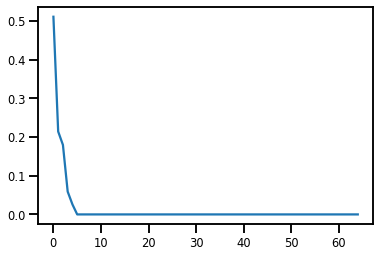

In [340]:
plt.plot(rbig_flow.losses)

100%|██████████| 65/65 [00:00<00:00, 834.38it/s]


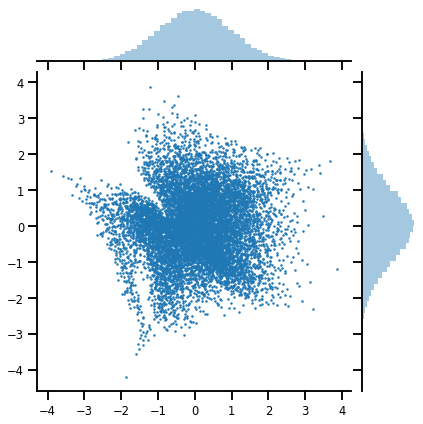

In [341]:
X_trans = rbig_flow.transform(np.array(data))

sns.jointplot(X_trans[:None, 0], X_trans[:None, 1], joint_kws={'s':1})

100%|██████████| 65/65 [00:00<00:00, 110.93it/s]


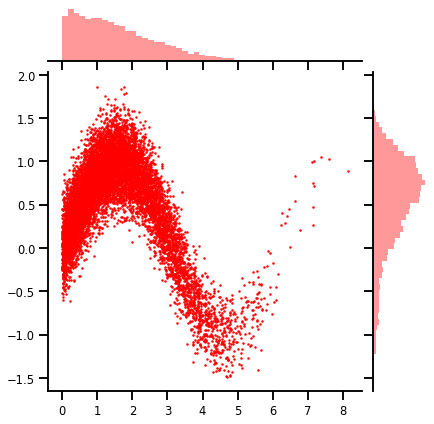

In [342]:
X_approx = rbig_flow.inverse_transform(X_trans)

sns.jointplot(X_approx[:None, 0], X_approx[:None, 1], joint_kws={'s':1}, color='red')

100%|██████████| 65/65 [00:00<00:00, 502.32it/s]


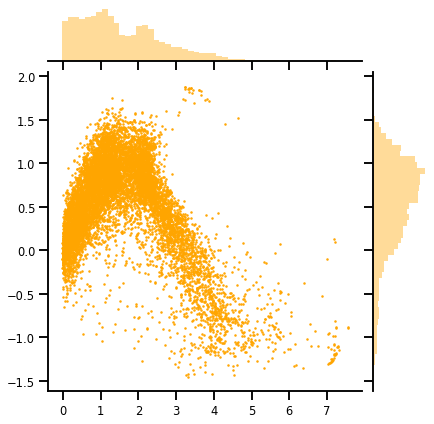

In [343]:
X_samples = rbig_flow.sample(10_000)

sns.jointplot(X_samples[:None, 0], X_samples[:None, 1], joint_kws={'s':1}, color='orange')